In [1]:
import sys
sys.path.append("../../../../src")
sys.path.append("../../")
import numpy as np
import pickle
from example_reactiondiffusion import get_rd_data
from autoencoder import full_network
from training import create_feed_dictionary
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
data_path_original = '../../sindy_models/original/'
data_path_verification = '../../sindy_models/verification/'

save_names = {
    data_path_original + 'model1': 'O1',
    data_path_original + 'model2': 'O2', 
}

for i in range(1, 11):
    save_names[data_path_verification + f'V{i}'] = f'V{i}'

coefficient_names = np.array([r'1', r'z_1', r'z_2',r'z_1^2', r'z_1z_2', r'z_2^2',r'z_1^3', r'z_1^2z_2', r'z_1 z_2^2', r'z_2^3', r'\sin(z_1)', r'sin(z_2)'], dtype=object)

# Test all 10 replicated models

In [4]:
_,_,test_data = get_rd_data()
test_data.keys()

dict_keys(['t', 'y1', 'y2', 'x', 'dx'])

In [5]:
results = {k: {} for k in save_names}

In [6]:
for save_name in save_names:
    tf.reset_default_graph()
    params = pickle.load(open( save_name + '_params.pkl', 'rb'))
    params['save_name'] =  save_name

    autoencoder_network = full_network(params)
    learning_rate = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
    saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

    tensorflow_run_tuple = ()
    for key in autoencoder_network.keys():
        tensorflow_run_tuple += (autoencoder_network[key],)

    # Test
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess,  save_name)
        test_dictionary = create_feed_dictionary(test_data, params)
        tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

    test_set_results = {}
    for i,key in enumerate(autoencoder_network.keys()):
        test_set_results[key] = tf_results[i]

    results[save_name]['z'] = test_set_results['z']
    results[save_name]['dz'] = test_set_results['dz']
    results[save_name]['coefficients'] = test_set_results['sindy_coefficients']
    results[save_name]['coefficient_mask'] = test_set_results['coefficient_mask']

INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model1
INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model2
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V1
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V2
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V3
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V4
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V5
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V6
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V7
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V8
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V9
INFO:tensorflow:Restoring parameters from ../../sindy_models/verification/V10


: 

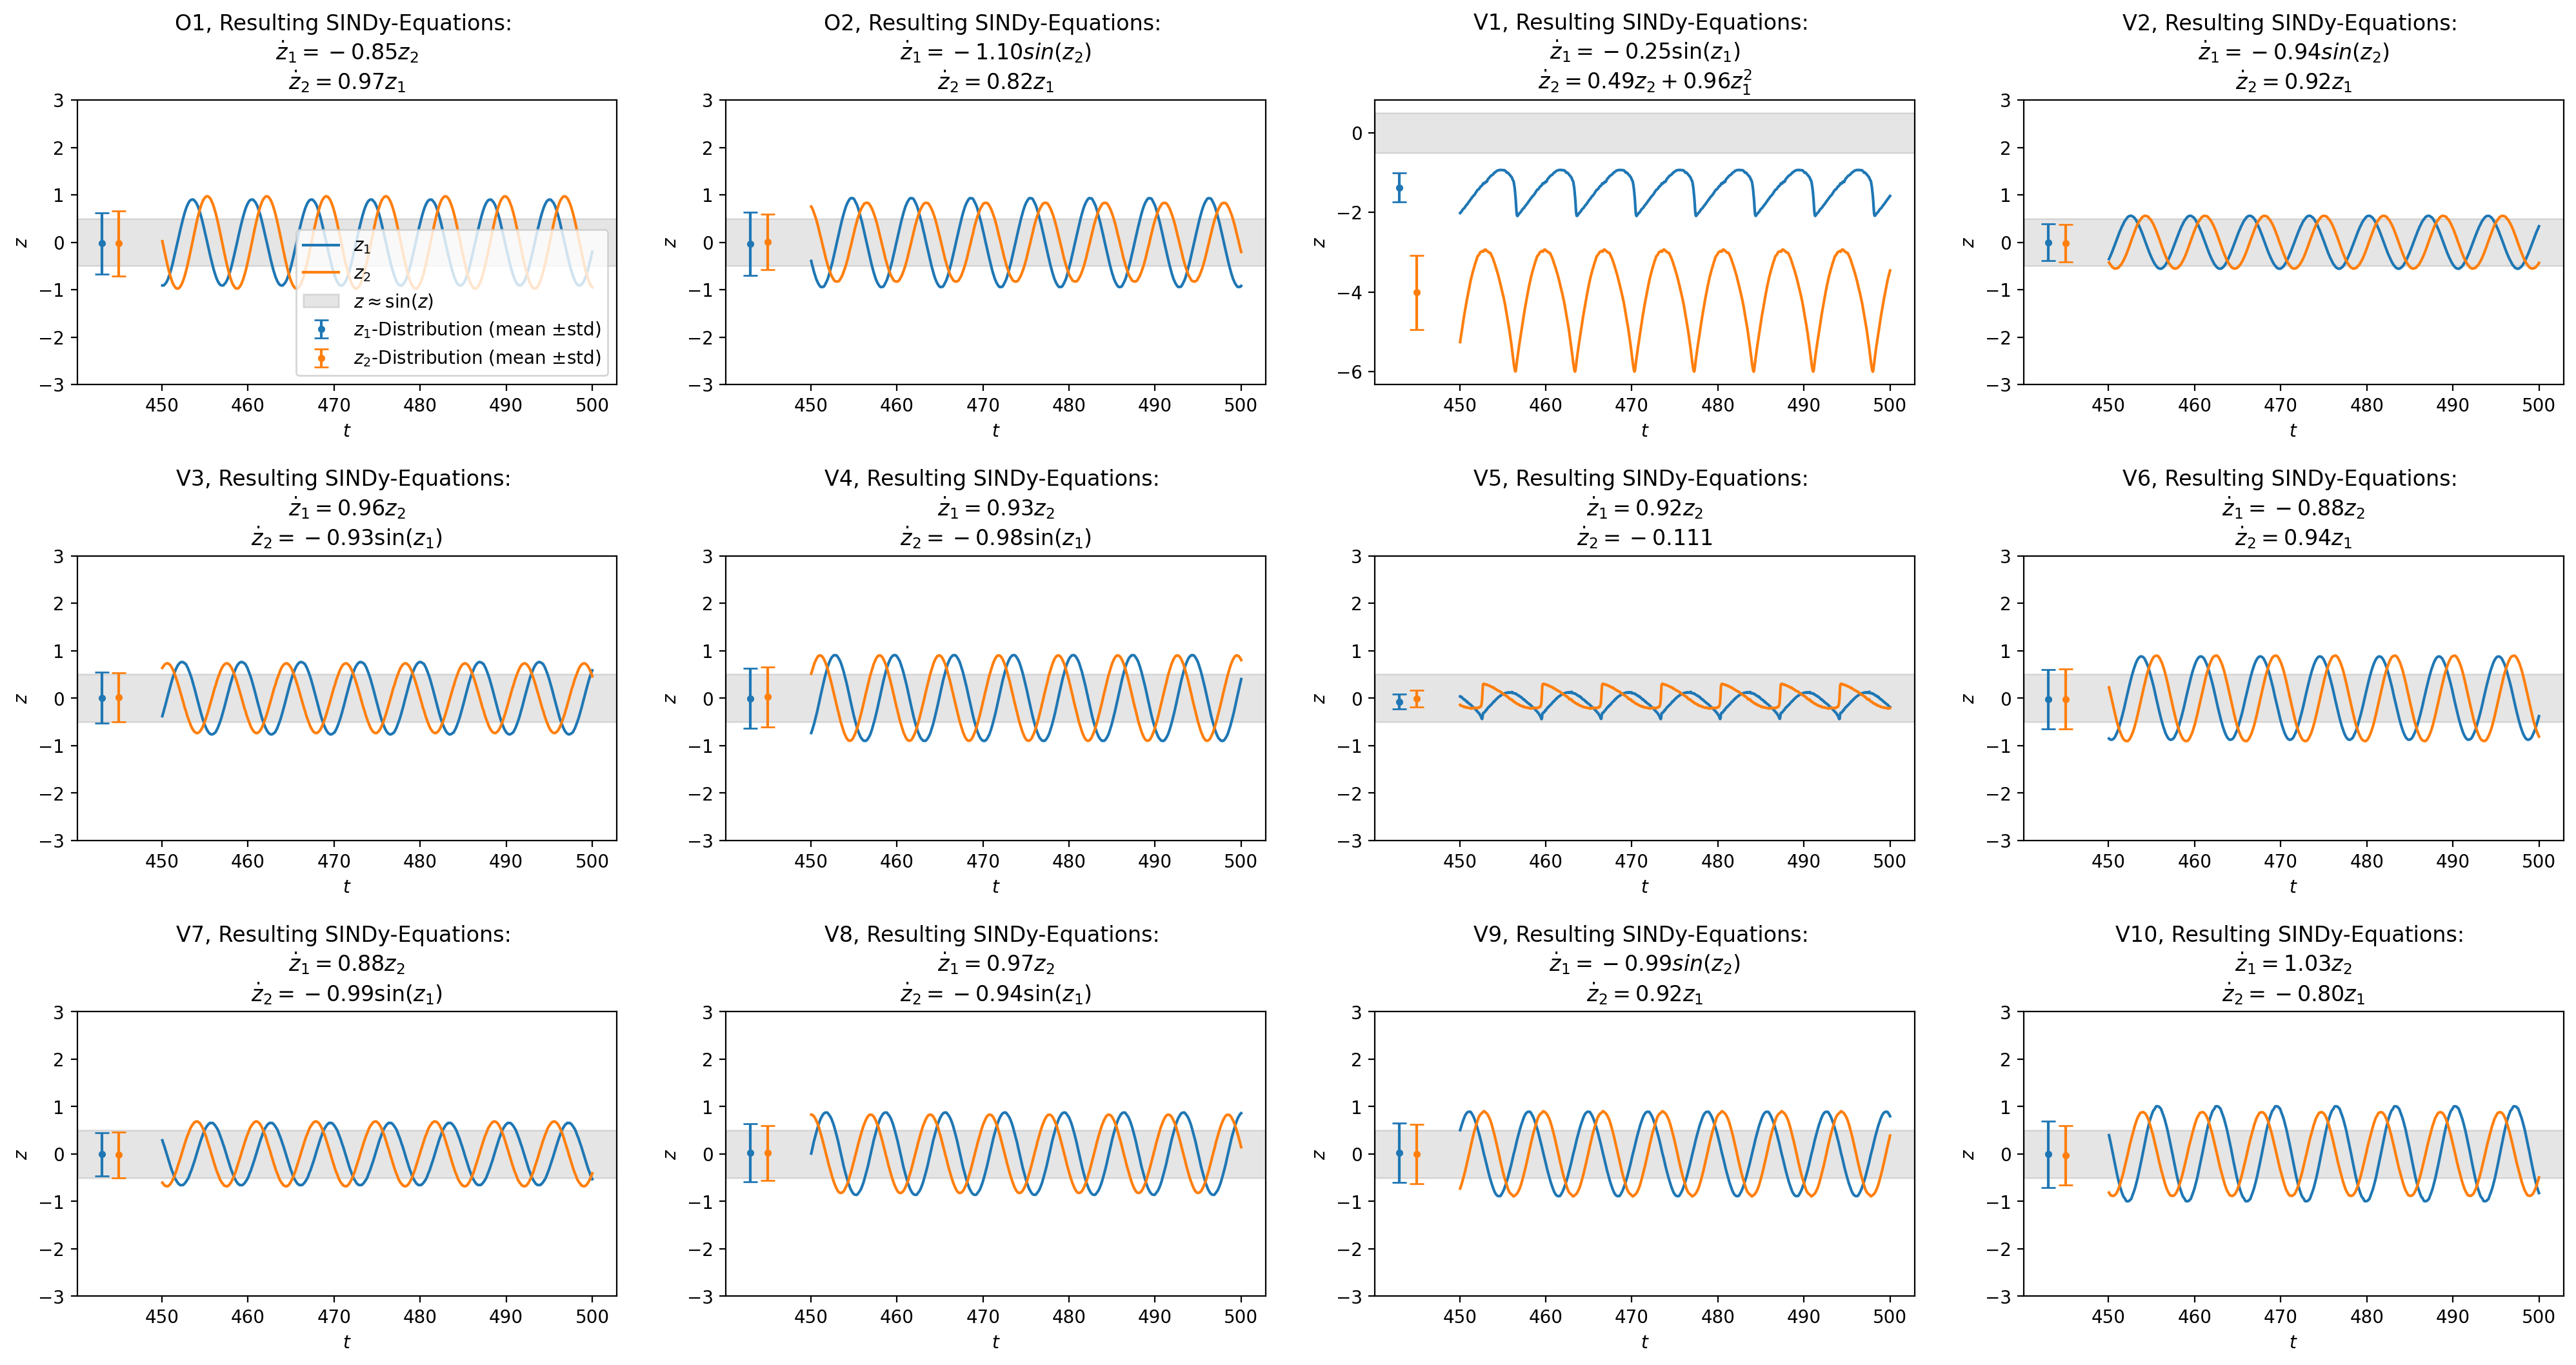

In [14]:
ROWS = 4

fig, axes = plt.subplots(3, ROWS, figsize=(44/2.2, 25/2.2), dpi=200)
fig.tight_layout(w_pad=3, h_pad=9)
fig.subplots_adjust(top=0.85)
# fig.suptitle(r'Vergleich der Repräsentation $z_i$ im latenten Raum in Abhängigkeit der Zeit.', fontsize=20)

z_linspace = np.linspace(-np.pi, np.pi, 100)

for i, save_name in enumerate(save_names):
    axes[i//ROWS][i%ROWS].plot(test_data['t'].flatten(), results[save_name]['z'][:, 0].flatten(),  label=r'$z_1$')
    axes[i//ROWS][i%ROWS].plot(test_data['t'].flatten(), results[save_name]['z'][:, 1].flatten(),  label=r'$z_2$')

    eq = ['' for _ in range(results[save_name]['coefficients'].shape[1])]

    for k in range(len(eq)):
        eq[k] = r'$\dot z_' + f'{k+1}' + ' = '
        for j, (coef, coef_name) in enumerate(zip(results[save_name]['coefficients'][:, k], coefficient_names)):
            # print(coef)
            if not results[save_name]["coefficient_mask"][:, k].astype(bool).flatten()[j]: continue
            eq[k] += ('+' if coef >= 0 and eq[k] != r'$\dot z_' + f'{k+1}' + ' = ' else '') + f'{coef:.2f}' + coef_name
        if not results[save_name]["coefficient_mask"][:, k].astype(bool).any(): eq[k] += '0'
        eq[k] += r'$'

    axes[i//ROWS][i%ROWS].errorbar([443], [np.mean(results[save_name]['z'][:, 0])], [np.std(results[save_name]['z'][:, 0])], capsize=4, fmt='.', label=r'$z_1$'+'-Distribution (mean ' + r'$\pm$' + 'std)' if i == 0 else None, color='tab:blue')
    axes[i//ROWS][i%ROWS].errorbar([445], [np.mean(results[save_name]['z'][:, 1])], [np.std(results[save_name]['z'][:, 1])], capsize=4, fmt='.', label=r'$z_2$'+'-Distribution (mean ' + r'$\pm$' + 'std)' if i == 0 else None, color='tab:orange')
    axes[i//ROWS][i%ROWS].axhspan(-0.5, 0.5, color='black', alpha=0.1, label=r'$z \approx \sin(z)$' if i == 0 else None)
    axes[i//ROWS][i%ROWS].set_title((f'V{i-1}' if i > 1 else f'O{i+1}') + ', Resulting SINDy-Equations: \n' + eq[0] + '\n' + eq[1])
    if i == 0: axes[i//ROWS][i%ROWS].legend(loc='lower right');
    axes[i//ROWS][i%ROWS].set_xlabel(r'$t$'); axes[i//ROWS][i%ROWS].set_ylabel(r'$z$');
    if i != 2: axes[i//ROWS][i%ROWS].set_ylim(-3, 3);

In [8]:
z1_stds = {save_name: np.std(results[save_name]['z'][:, 0]) for save_name in save_names}
z2_stds = {save_name: np.std(results[save_name]['z'][:, 1]) for save_name in save_names}

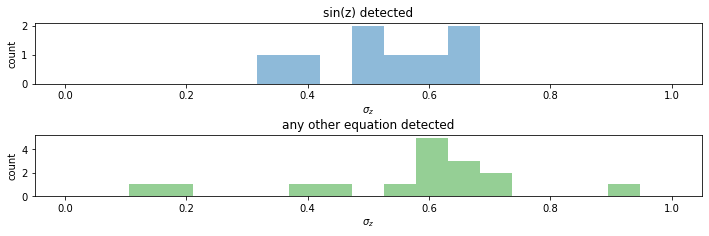

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 3))
fig.tight_layout(h_pad=3)

axes[0].hist(np.hstack([[z1_stds[save_names[i]] for i in range(len(save_names)) if i in [1, 2, 3, 10]], [z2_stds[save_names[i]] for i in range(len(save_names)) if i in [4, 5, 8, 9]]]), bins=np.linspace(0, 1, 20), alpha=0.5, color='tab:blue')
axes[0].set_title('sin(z) detected')
axes[1].hist(np.hstack([[z1_stds[save_names[i]] for i in range(len(save_names)) if i not in [1, 2, 3, 10]], [z2_stds[save_names[i]] for i in range(len(save_names)) if i not in [4, 5, 8, 9]]]), bins=np.linspace(0, 1, 20), alpha=0.5, color='tab:green')
axes[1].set_title('any other equation detected')

for ax in axes:
    ax.set_xlabel(r'$\sigma_z$'), ax.set_ylabel('count')